In [1]:
from edahelper import *
import sklearn.naive_bayes as NB
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
# Resources:
## Import all the keras stuff we'll need
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from keras.preprocessing import sequence
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
import pandas as pd
import gensim
import re
import nltk
#https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html


Using TensorFlow backend.
/Users/karp/opt/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
wsb = pd.read_csv('../Data/wsb_cleaned.csv')
#wsb = pd.read_csv('../Data/subreddits.csv')

In [3]:
#set up appropriate subset, removing comment outliers
#also chose to look at only self posts
dfog=wsb.loc[(wsb.is_self==True) & (wsb.ups>=10) & (wsb.num_comments<=10000) & ~(wsb["title"].str.contains("Thread|thread|Sunday Live Chat|consolidation zone|Containment Zone|Daily Discussion|Daily discussion|Saturday Chat|What Are Your Moves Tomorrow|What Are Your Moves Today|MEGATHREAD",na=False))]

In [4]:
def RegexCols(df,cols):
    newdf=df
    regex = re.compile('[^a-zA-Z ]')
    for col in cols:
        newdf=newdf.assign(**{col: df.loc[:,col].apply(lambda x : regex.sub('', str(x) ))})
    return newdf

df=RegexCols(dfog,['title', 'author', 'selftext'])

max_ups=df.ups.max()
print('max upvotes is ', max_ups)
num_clean=len(df.ups)
print('number of cleaned posts is',num_clean)
df['pop']=np.zeros(num_clean)


max upvotes is  194994
number of cleaned posts is 76145


In [5]:
checksum1=sum(df['pop'])
print('The initial checksum is',checksum1,'= 0')
for i in df.index:
    if df.loc[i,('ups')] >= 250:
        df.loc[i,('pop')] = 1
checksum2=sum(df['pop'])
percentpop = "{:.2f}".format(checksum2/num_clean*100)
print('The number of popular posts is',checksum2,'\n','or',percentpop, '% of all posts')  

The initial checksum is 0.0 = 0
The number of popular posts is 8206.0 
 or 10.78 % of all posts


In [6]:
df['selftext'].head()

4                                               removed
7     Alright WSBSo I recently came into about k due...
10    I saw an older thread on it curious who is sti...
13                                              deleted
22                                              removed
Name: selftext, dtype: object

In [7]:
#df = pd.read_csv("../../Data/subreddits.csv", nrows = 1000)
regex = re.compile('[^a-zA-Z ]')

def tokenize(text):
    sentences = []
    if type(text) == str:
        for sentence in nltk.tokenize.sent_tokenize(text):
            processed = [regex.sub('', word.lower()) for word in sentence.split(' ') ]
            processed = [word for word in processed if word not in set( ['' ])]
            sentences.append(processed)
    return sentences

df['tokenized_title'] = df.title.apply(tokenize)
tokenized_text = df['tokenized_title']
corpus = []

for tokenized in tokenized_text:
    corpus += tokenized

dictionary = gensim.corpora.dictionary.Dictionary(documents = corpus)
dictionary.filter_extremes(no_below = 10)

word_dictionary = dict(dictionary)
word_dictionary
corpus

[['i', 'will', 'remember'],
 ['new', 'years', 'challenge', 'k', 'makeit', 'or', 'breakit'],
 ['how',
  'many',
  'of',
  'you',
  'tisms',
  'are',
  'doing',
  'the',
  'uprotmf',
  'mix'],
 ['exclusive',
  'airbus',
  'beats',
  'goal',
  'with',
  'jet',
  'deliveries',
  'in',
  'ousts',
  'boeing',
  'from',
  'top',
  'spot'],
 ['day', 'trading', 'how', 'i', 'lost', 'it', 'all'],
 ['markets',
  'are',
  'on',
  'the',
  'cusp',
  'of',
  'a',
  'correction',
  'and',
  'theres',
  'opportunity',
  'for',
  'mega',
  'tendies',
  'in',
  'the',
  'next',
  'month'],
 ['literally', 'free', 'money'],
 ['advanced', 'portfolio', 'funding', 'strategy'],
 ['real',
  'reason',
  'intel',
  'why',
  'failed',
  'to',
  'deliver',
  'nm',
  'for',
  'so',
  'long',
  'is',
  'because',
  'of',
  'feminism'],
 ['how',
  'we',
  'can',
  'all',
  'be',
  'retarded',
  'millionaires',
  'by',
  'the',
  'end',
  'of'],
 ['friendly',
  'reminder',
  'futures',
  'markets',
  'open',
  'at',
  

In [8]:
dictionary

In [9]:
max_features = 40000

titles=np.array(df['title'])
word_tokenizer = Tokenizer(max_features)
word_tokenizer.fit_on_texts(titles)

print(str(word_tokenizer.word_counts)[0:100])
print(str(word_tokenizer.word_index)[0:100])
print(len(word_tokenizer.word_counts))   # true word count
titles_tf = word_tokenizer.texts_to_sequences(titles)

print(titles_tf[0])
maxlen = 20
titles_tf = sequence.pad_sequences(titles_tf, maxlen=maxlen)

print(titles_tf[0])

OrderedDict([('i', 7211), ('will', 3104), ('remember', 334), ('new', 1262), ('years', 207), ('challe
{'the': 1, 'to': 2, 'and': 3, 'gme': 4, 'is': 5, 'a': 6, 'of': 7, 'on': 8, 'you': 9, 'for': 10, 'in'
25668
[12, 25, 269]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  12
  25 269]


In [10]:
X=titles_tf
y=np.array(df['pop'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46, stratify=y)

#X_train, X_test, y_train, y_test = train_test_split(df['selftext'], df['pop'], test_size=0.2, random_state=46, stratify=y)

print("The shape of our Xs prior to becoming sequences")
print("X_train:", np.shape(X_train))
print("X_test:", np.shape(X_test))


The shape of our Xs prior to becoming sequences
X_train: (60916, 20)
X_test: (15229, 20)


In [11]:
model = models.Sequential()
## Embedding is added first
## the size of our dictionary is the first input
## followed by the desired embedding size, I chose 50
model.add(layers.Embedding(max_features, 50))

## Then the simplernn layer
## return_sequences determines if the network should return the hidden state value for 
## each hidden layer h1, h2, ..., hT
## Since we only want the last one, hT, we set it equal to False
## If we were building a network with multiple SimpleRNN layers,
## like you are later, you'll set this to True
model.add(layers.SimpleRNN(50, return_sequences=False))
## Finally we'll add a Dense Layer for classification
## purposes
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [12]:
## Making our validation set
from sklearn.model_selection import train_test_split

X_train_train,X_val,y_train_train,y_val = train_test_split(X_train, y_train,
                                                           test_size=.2,
                                                           shuffle=True,
                                                           random_state=440)

In [13]:
num_epochs=10
history = model.fit(X_train_train, y_train_train,
                    epochs = num_epochs,
                    batch_size=128,
                    validation_data=(X_val,y_val))

## Note training this model can take a while
history_dict = history.history

/Users/karp/opt/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 48732 samples, validate on 12184 samples
Epoch 1/10
48732/48732 [==============================] - 32s 656us/step - loss: 0.3361 - accuracy: 0.8911 - val_loss: 0.3377 - val_accuracy: 0.8889
Epoch 2/10
48732/48732 [==============================] - 31s 637us/step - loss: 0.3053 - accuracy: 0.8941 - val_loss: 0.3474 - val_accuracy: 0.8845
Epoch 3/10
48732/48732 [==============================] - 31s 636us/step - loss: 0.2541 - accuracy: 0.9098 - val_loss: 0.3892 - val_accuracy: 0.8647
Epoch 4/10
48732/48732 [==============================] - 29s 599us/step - loss: 0.2091 - accuracy: 0.9268 - val_loss: 0.4465 - val_accuracy: 0.8386
Epoch 5/10
48732/48732 [==============================] - 31s 627us/step - loss: 0.1771 - accuracy: 0.9397 - val_loss: 0.5432 - val_accuracy: 0.7903
Epoch 6/10
48732/48732 [==============================] - 31s 638us/step - loss: 0.1561 - accuracy: 0.9477 - val_loss: 0.5167 - val_accuracy: 0.8314
Epoch 7/10
48732/48732 [==============================] 

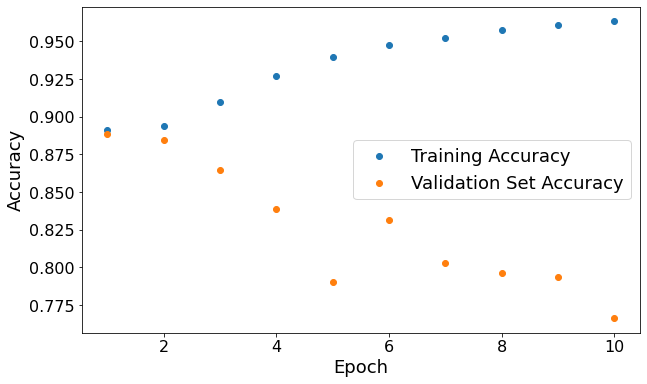

In [14]:
## Plotting the training and validation accuracy
plt.figure(figsize = (10,6))

plt.scatter(range(1,num_epochs+1), history_dict['accuracy'], label = "Training Accuracy")
plt.scatter(range(1,num_epochs+1), history_dict['val_accuracy'], label = "Validation Set Accuracy")

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18)

plt.show()

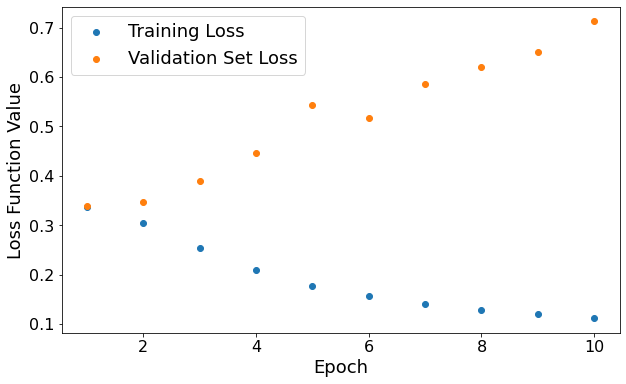

In [15]:
## Plotting the training and validation loss
plt.figure(figsize = (10,6))

plt.scatter(range(1,num_epochs+1), history_dict['loss'], label = "Training Loss")
plt.scatter(range(1,num_epochs+1), history_dict['val_loss'], label = "Validation Set Loss")

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Loss Function Value", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18)

plt.show()